# Lesson 01: Data Collection - Scraping ANPC Press Releases

In this notebook, we'll learn how to build a web scraper to collect a dataset
of Romanian text for NLP analysis. We'll scrape press releases from ANPC 
(Autoritatea Națională pentru Protecția Consumatorilor - the Romanian consumer
protection authority).

## Learning Objectives

1. Understand the difference between static and dynamic web scraping
2. Use Playwright for rendering JavaScript-heavy pages
3. Implement respectful scraping practices (rate limiting, user agents)
4. Handle errors gracefully with retry logic
5. Structure scraped data for NLP tasks

## 1. Why Web Scraping for NLP?

Building NLP models requires large amounts of text data. While many datasets
exist, domain-specific applications often need custom datasets:

- **Domain specificity**: Legal, medical, or institutional language
- **Language coverage**: Less-resourced languages like Romanian
- **Temporal relevance**: Up-to-date information
- **Data ownership**: Control over your training data

ANPC press releases provide:
- Formal Romanian language
- Legal/regulatory terminology
- Structured announcements
- Regular publication schedule

## 2. Static vs Dynamic Scraping

### Static Pages (requests + BeautifulSoup)
- HTML content is in the initial response
- Faster, simpler
- Example: Wikipedia, news article text

### Dynamic Pages (Playwright/Selenium)
- Content is loaded via JavaScript
- Requires a real browser engine
- Example: Single-page apps, infinite scroll

**ANPC uses dynamic loading**, so we need Playwright or Selenium.

In [ ]:
# Let's verify our setup
import sys
from pathlib import Path

# Add the parent directory to path for imports
sys.path.insert(0, str(Path.cwd().parent))

print(f"Python version: {sys.version}")
print(f"Working directory: {Path.cwd()}")

Python version: 3.12.10 (main, Apr  9 2025, 04:03:51) [Clang 20.1.0 ]
Working directory: /home/marius/ore/inlp/gh/inlp/01_data_collection/notebooks


In [ ]:
# Check if Playwright is installed
try:
    from playwright.async_api import async_playwright
    print("✅ Playwright is installed")
except ImportError:
    print("❌ Playwright not found. Run: uv run playwright install chromium")

✅ Playwright is installed


## 3. Understanding the Target Website

Before scraping, we need to understand the website structure:

- **Index pages**: `https://anpc.ro/category/comunicate-de-presa/bpage/{page}/`
  - Pages 1-12 contain links to articles
  - Each page has multiple article cards

- **Article pages**: Individual press releases with:
  - Title (in the `<title>` tag)
  - Content (main text body)
  - Date and time of publication

## 4. Ethical Scraping Practices

Always be a good citizen when scraping:

1. **Check robots.txt**: Respect what the site allows
2. **Rate limiting**: Don't overwhelm the server
3. **Identify yourself**: Use a descriptive User-Agent
4. **Cache results**: Don't re-scrape unchanged content
5. **Respect copyright**: Understand data usage rights

In [ ]:
import scrapers

In [ ]:

# For debugging when not running the interactive notebook
# from importlib import reload
# # del scrapers
# import scrapers
# reload(scrapers.anpc_scraper)

In [ ]:
# Let's look at our scraper configuration
from scrapers.anpc_scraper import (
    BASE_URL,
    INDEX_URL_TEMPLATE,
    REQUEST_DELAY_SECONDS,
    MAX_RETRIES,
    INITIAL_BACKOFF_SECONDS,
)

print(f"Base URL: {BASE_URL}")
print(f"Index template: {INDEX_URL_TEMPLATE}")
print(f"Request delay: {REQUEST_DELAY_SECONDS}s")
print(f"Max retries: {MAX_RETRIES}")
print(f"Initial backoff: {INITIAL_BACKOFF_SECONDS}s")

Base URL: https://anpc.ro
Index template: https://anpc.ro/category/comunicate-de-presa/bpage/{page}/
Request delay: 1.0s
Max retries: 3
Initial backoff: 2.0s


## 5. Running the Scraper

Let's scrape a small sample to see how it works.

**Note**: On first run, this will:
1. Visit the index page
2. Extract article links
3. Visit each article page
4. Save raw HTML and structured data

In [ ]:
# Import the scraper functions
from scrapers.anpc_scraper import scrape_page, load_existing_articles

# Check what we already have
existing = load_existing_articles()
print(f"Existing articles: {len(existing)}")

Existing articles: 237


In [ ]:
# Scrape just 2 articles from page 1 (for demonstration)
# This will take about 5-10 seconds
print("Scraping 2 articles from page 1...")
articles = await scrapers.anpc_scraper.scrape_page(page_num=1, max_articles=2)
print(f"\nScraped {len(articles)} articles")

Scraping 2 articles from page 1...


2025-12-22 18:22:25,332 - INFO - Scraping index page 1: https://anpc.ro/category/comunicate-de-presa/bpage/1/
2025-12-22 18:22:31,171 - INFO - Found 20 articles on page 1
2025-12-22 18:22:31,171 - INFO - Urls: ['https://anpc.ro/comandament-anpc-in-zonele-turistice/', 'https://anpc.ro/controale-anpc-peste-1-600-de-operatori-economici-verificati-la-nivel-national/', 'https://anpc.ro/controale-anpc-amenzi-de-peste-144-milioane-de-lei-aplicate-in-intreaga-tara/', 'https://anpc.ro/controale-anpc-la-marile-magazine-amenzi-de-aproximativ-32-milioane-de-lei-in-doar-2-zile/', 'https://anpc.ro/actiuni-de-control-anpc-in-targurile-de-craciun/', 'https://anpc.ro/anpc-a-aplicat-sanctiuni-de-aproximativ-423-milioane-de-lei-in-urma-controalelor-nationale/', 'https://anpc.ro/protectia-consumatorilor-in-achizitia-de-locuinte-aspecte-esentiale-si-siguranta-tranzactiilor-imobiliare/', 'https://anpc.ro/supraveghere-constanta-a-pietei-de-catre-anpc-rezultatele-activitatii-saptamanale-3/', 'https://anpc.ro/


Scraped 2 articles


In [ ]:
# Let's examine one article
if articles:
    article = articles[0]
    print("=" * 60)
    print(f"Title: {article['title']}")
    print(f"Date: {article['date']}")
    print(f"Time: {article['time']}")
    print(f"URL: {article['url']}")
    print("=" * 60)
    print("\nContent preview (first 500 chars):")
    print(article['content'] if article['content'] else "(no content)")

Title: Comandament ANPC în zonele turistice
Date: 22 decembrie 2025
Time: 3:34 pm
URL: https://anpc.ro/comandament-anpc-in-zonele-turistice/

Content preview (first 500 chars):
În perioada 15.12.2025–21.12.2025, Autoritatea Națională pentru Protecția Consumatorilor,prin Comandamentul de Iarnă 2025, a verificat activitateaa peste 470 de operatori economicidin stațiunile și zonele turistice. ANPC este prezent în toate zonele turistice pe întreaga durată a sezonului sărbătorilor de iarnă, pentru a garanta protecția și drepturile consumatorilor.

Ca urmare a neconformităților constatate, comisarii ANPC au aplicat următoarele sancțiuni:

271 de amenzi contravenţionale,în valoare de aproximativ1,6 milioane de lei

296 de avertismente

oprirea definitivă de la comercializarea produselor neconforme, în valoare de peste65.000 lei

oprirea temporară de la comercializarea unor produse în valoare de peste73.000 lei

oprirea prestării serviciilorpână la remedierea deficiențelor pentru8 operatori ec

## 6. Exploring the Scraped Data

In [ ]:
import json
from pathlib import Path

# Load all scraped articles
data_file = Path("../data/processed/articles_anpc.json")
if data_file.exists():
    with open(data_file, "r", encoding="utf-8") as f:
        all_articles = json.load(f)
    print(f"Total articles: {len(all_articles)}")
else:
    all_articles = articles  # Use what we just scraped
    print(f"Using freshly scraped articles: {len(all_articles)}")

Total articles: 237


In [ ]:
# Basic statistics
if all_articles:
    content_lengths = [len(a.get("content", "")) for a in all_articles]
    
    print(f"Articles with content: {sum(1 for l in content_lengths if l > 0)}")
    print(f"Average content length: {sum(content_lengths) / len(content_lengths):.0f} chars")
    print(f"Shortest: {min(content_lengths)} chars")
    print(f"Longest: {max(content_lengths)} chars")

Articles with content: 237
Average content length: 2289 chars
Shortest: 16 chars
Longest: 19347 chars


## 7. Visualizing the Data

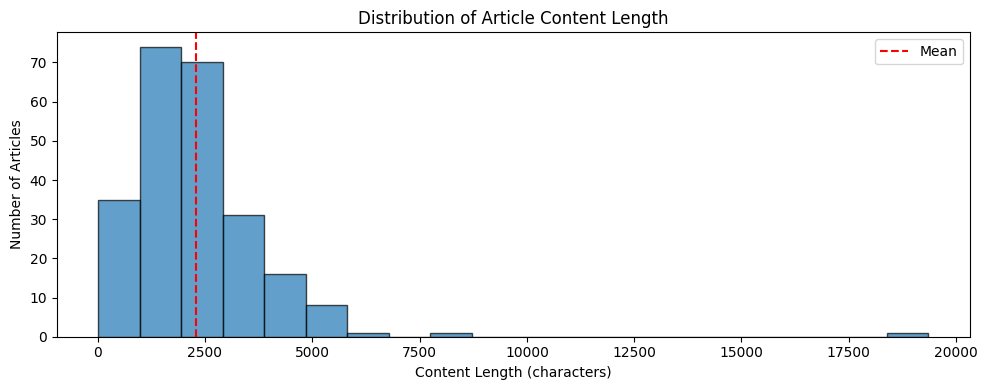

In [ ]:
# Content length distribution

import matplotlib.pyplot as plt

if all_articles and any(content_lengths):
    plt.figure(figsize=(10, 4))
    plt.hist(content_lengths, bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Content Length (characters)')
    plt.ylabel('Number of Articles')
    plt.title('Distribution of Article Content Length')
    plt.axvline(sum(content_lengths)/len(content_lengths), 
                color='red', linestyle='--', label='Mean')
    plt.legend()
    plt.tight_layout()
    plt.show()

## 8. Raw HTML Storage

We also save the raw HTML for each article. This is useful for:
- Re-extracting data with different selectors
- Debugging extraction issues
- Preserving the original format

In [ ]:
# Check raw HTML files
raw_html_dir = Path("../data/raw_html")
if raw_html_dir.exists():
    html_files = list(raw_html_dir.glob("*.html"))
    print(f"Raw HTML files: {len(html_files)}")
    
    if html_files:
        # Show sample
        sample_file = html_files[0]
        content = sample_file.read_text(encoding="utf-8")
        print(f"\nSample file: {sample_file.name}")
        print(f"Size: {len(content):,} bytes")
        print(f"Preview: {content[:200]}...")
else:
    print("No raw HTML files yet - run the scraper first")

Raw HTML files: 237

Sample file: anpc-a-controlat-magazinele-selgros-din-toata-tara.html
Size: 642,326 bytes
Preview: <!DOCTYPE html><html lang="ro-RO" data-uw-w-loader=""><head><script async="" src="https://www.googletagmanager.com/gtm.js?id=G-FDVTGP2007"></script><script data-no-optimize="1">var litespeed_docref=se...


## 9. Comparing Playwright vs Selenium

We also have a Selenium version for educational purposes:

| Feature | Playwright | Selenium |
|---------|-----------|----------|
| Async support | ✅ Native | ❌ Requires threading |
| Auto-wait | ✅ Built-in | ❌ Manual waits |
| Browser download | ✅ Simple CLI | ❌ WebDriverManager |
| Speed | 🚀 Faster | 🐢 Slower |
| API | Modern, clean | Older, verbose |

**Recommendation**: Use Playwright for new projects.

In [ ]:
# To scrape everything (takes ~30 minutes):
from scrapers.anpc_scraper import scrape_articles

async def full_scrape():
    articles = await scrape_articles()
    print(f"Total articles: {len(articles)}")

# asyncio.run(full_scrape())
await full_scrape()

2025-12-22 18:22:35,726 - INFO - Found 237 existing articles
2025-12-22 18:22:36,096 - INFO - Scraping index page 1: https://anpc.ro/category/comunicate-de-presa/bpage/1/
2025-12-22 18:22:41,831 - INFO - Found 20 articles on page 1
2025-12-22 18:22:42,832 - INFO - Scraping index page 2: https://anpc.ro/category/comunicate-de-presa/bpage/2/
2025-12-22 18:22:48,796 - INFO - Found 20 articles on page 2
2025-12-22 18:22:49,797 - INFO - Scraping index page 3: https://anpc.ro/category/comunicate-de-presa/bpage/3/
2025-12-22 18:22:55,718 - INFO - Found 20 articles on page 3
2025-12-22 18:22:56,720 - INFO - Scraping index page 4: https://anpc.ro/category/comunicate-de-presa/bpage/4/
2025-12-22 18:23:02,607 - INFO - Found 20 articles on page 4
2025-12-22 18:23:03,609 - INFO - Scraping index page 5: https://anpc.ro/category/comunicate-de-presa/bpage/5/
2025-12-22 18:23:10,583 - INFO - Found 20 articles on page 5
2025-12-22 18:23:11,585 - INFO - Scraping index page 6: https://anpc.ro/category/com

Total articles: 237


In [ ]:
# To reprocess already downloaded HTML files:
from scrapers.anpc_scraper import reprocess_saved_html
reprocess_saved_html()

2025-12-22 18:24:12,822 - INFO - Saved 237 articles to /home/marius/ore/inlp/gh/inlp/01_data_collection/data/processed/articles.json
2025-12-22 18:24:12,823 - INFO - Reprocessed 237 articles from raw HTML.


[{'url': 'https://anpc.ro/comandament-anpc-in-zonele-turistice/',
  'title': 'Comandament ANPC în zonele turistice',
  'content': 'În perioada 15.12.2025–21.12.2025, Autoritatea Națională pentru Protecția Consumatorilor,prin Comandamentul de Iarnă 2025, a verificat activitateaa peste 470 de operatori economicidin stațiunile și zonele turistice. ANPC este prezent în toate zonele turistice pe întreaga durată a sezonului sărbătorilor de iarnă, pentru a garanta protecția și drepturile consumatorilor.\n\nCa urmare a neconformităților constatate, comisarii ANPC au aplicat următoarele sancțiuni:\n\n271 de amenzi contravenţionale,în valoare de aproximativ1,6 milioane de lei\n\n296 de avertismente\n\noprirea definitivă de la comercializarea produselor neconforme, în valoare de peste65.000 lei\n\noprirea temporară de la comercializarea unor produse în valoare de peste73.000 lei\n\noprirea prestării serviciilorpână la remedierea deficiențelor pentru8 operatori economici.\n\nPrincipaleleneconformi

## 10. Next Steps

With our dataset collected, we can proceed to:

1. **Lesson 02: Preprocessing** - Clean and normalize the text
2. **Lesson 03: EDA** - Explore patterns in the data
3. **Lesson 04+**: Build NLP models

### Exercises

1. Run the scraper to see if it works (if it does not, debug it and raise an issue; or even better, a pull request)
2. Add a scraper for a different Romanian news source
3. Implement near-duplicate detection with LSH; also check out [here](https://github.com/ChenghaoMou/text-dedup) for other deduplication methods
4. Investigate what is the issue with the "16 chars" article